In [8]:
from model import *
from helpers import *

In [9]:
results = run_model(V_C=10.5,W_sea=0,t_max=10,W_LIP=9,tau=18,V_red=0)
sb_starts, sb_ends, sb_durs, ig_durs = get_times(results['t'],results['snowball'])
print(f"Shortest possible Snowball: {sb_durs[0]:0.2f} Myr")

results = run_model(V_C=6.5,W_sea=2.4,t_max=10,W_LIP=9,tau=18,V_red=0)
sb_starts, sb_ends, sb_durs, ig_durs = get_times(results['t'],results['snowball'])
print(f"Longest possible Snowball: {sb_durs[0]:0.2f} Myr")

Shortest possible Snowball: 1.81 Myr
Longest possible Snowball: 4.59 Myr


In [10]:
def get_first_snowball_duration(results):
    t = results['t']
    snowball = results['snowball']

    starts, ends, durations, _ = get_times(t, snowball)
    if durations:
        return durations[0]
    return np.nan

In [11]:
def sweep_snowball_durations(V_C_array, W_sea_array, default_params,verbose=False):
    duration_grid = np.full((len(W_sea_array), len(V_C_array)), np.nan)

    for i, W_sea in enumerate(W_sea_array):
        if verbose:
            print(f"Running with W_sea={W_sea:0.2f}...")
        for j, V_C in enumerate(V_C_array):
            if verbose:
                print(f"    Running with V_C={V_C:0.2f}...")
            params = default_params.copy()
            params['V_C'] = V_C
            params['W_sea'] = W_sea

            try:
                results = run_model(**params)
                duration_grid[i, j] = get_first_snowball_duration(results)
            except Exception:
                pass

    return duration_grid

In [13]:
# Parameter ranges
V_C_values = np.linspace(6.5, 10.5, 30)
W_sea_values = np.linspace(0.0, 2.4, 30)

# Default parameters
default_params = {
    "tau": 18,
    "W_LIP": 9,
    "dt":1e4/1e6,
    "t_max": 10,
    "V_red":0
}

# Run sweep
snowball_duration_grid = sweep_snowball_durations(V_C_values, W_sea_values, default_params)

/Users/cminsky/Documents/Research/Sturtian-limit-cycles/model.py:145: UserWarning: Carbon cycle out of balance by 1.78e-15
  warnings.warn(f"Carbon cycle out of balance by {np.abs(dNdt):0.2e}")
/Users/cminsky/Documents/Research/Sturtian-limit-cycles/model.py:145: UserWarning: Carbon cycle out of balance by 1.33e-15
  warnings.warn(f"Carbon cycle out of balance by {np.abs(dNdt):0.2e}")
/Users/cminsky/Documents/Research/Sturtian-limit-cycles/model.py:145: UserWarning: Carbon cycle out of balance by 1.11e-15
  warnings.warn(f"Carbon cycle out of balance by {np.abs(dNdt):0.2e}")


In [14]:
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d

def plot_snowball_duration_contour(V_C_array, W_sea_array, duration_grid, 
                                   cmap='viridis',
                                   W_sea_value=1.6, V_C_value=8.5):
    
    V_C_mesh, W_sea_mesh = np.meshgrid(V_C_array, W_sea_array)

    # set up grid layout
    fig = plt.figure(figsize=(8, 7))
    gs = GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[4, 1], hspace=0.3, wspace=0.3)

    ax_contour = fig.add_subplot(gs[0, 0])
    ax_hslice  = fig.add_subplot(gs[1, 0], sharex=ax_contour)
    ax_vslice  = fig.add_subplot(gs[0, 1], sharey=ax_contour)

    # --- main plot ---
    cs = ax_contour.contour(V_C_mesh, W_sea_mesh, duration_grid,
                            levels=10, cmap=cmap, linewidths=2)
    ax_contour.clabel(cs, inline=True, fontsize=8, colors='black',
                      fmt=lambda x: f"{x:.1f} Myr")
    ax_contour.set_xlabel("Volcanic CO$_2$ [Tmol C/yr]")
    ax_contour.set_ylabel("Seafloor weathering [Tmol C/yr]")
    ax_contour.set_title("Duration of first Snowball")

    # --- horizontal slice (fixed W_sea) ---
    duration_hslice = [
        interp1d(W_sea_array, duration_grid[:, i], kind='linear', bounds_error=False, fill_value='extrapolate')(W_sea_value)
        for i in range(len(V_C_array))
    ]
    ax_hslice.plot(V_C_array, duration_hslice, color='black')
    ax_hslice.set_ylabel("Duration [Myr]")
    ax_hslice.set_xlabel("Volcanic CO$_2$ [Tmol C/yr]")
    ax_hslice.text(0.95, 0.85, f"Seafloor weathering\n= {W_sea_value:.1f} Tmol C/yr",
                   transform=ax_hslice.transAxes,
                   fontsize=9, ha='right', va='top')

    # --- vertical slice (fixed V_C) ---
    duration_vslice = [
        interp1d(V_C_array, duration_grid[j, :], kind='linear', bounds_error=False, fill_value='extrapolate')(V_C_value)
        for j in range(len(W_sea_array))
    ]
    ax_vslice.plot(duration_vslice, W_sea_array, color='black')
    ax_vslice.set_xlabel("Duration [Myr]")
    ax_vslice.set_ylabel("Seafloor weathering [Tmol C/yr]")
    ax_vslice.text(0.1, 0.98, f"Volc. CO$_2$ =\n{V_C_value:.1f} Tmol C/yr",
                   transform=ax_vslice.transAxes,
                   fontsize=9, ha='left', va='top')

    # format
    plt.setp(ax_hslice.get_xticklabels(), rotation=0)
    plt.setp(ax_vslice.get_yticklabels(), visible=True)

    return fig


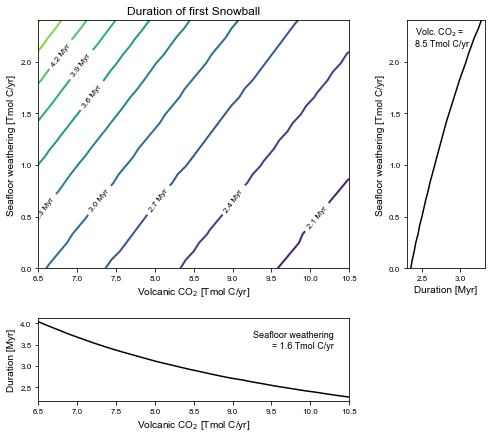

In [15]:
fig = plot_snowball_duration_contour(V_C_values, W_sea_values,
                                     snowball_duration_grid)
figname="sbdur_volc.pdf"
savefig(fig,figname,savefmt='pdf',supp_folder="supp")